# Optimization

[What is Bond listening to right now?](https://www.youtube.com/watch?v=zf3JJmMxoxs&list=RDzf3JJmMxoxs&start_radio=1) 

This Notebook provides an introduction to the concept of ***optimization*** in reactor design. So far, the material presented in this course might give us the impression that we'll always be told what the target is in our design problem. For example, we have to this point seen many questions of the form:

1. How long should this reaction occur in a batch reactor to achieve 75% conversion of the limiting reactant?
2. How large (volume) should the flow reactor (CSTR or PFR) be to acheive 60% conversion of the limiting reactant?
3. What conversion of the limiting reactant will be achieved after 15 minutes in a batch reactor? 
4. What conversion of the limiting reactant will be achieved in a 12L CSTR or a 22L PFR?

More frequently, we might find that we are the experts on reactor design, and we may instead have to answer questions like:

1. How long should we let this reaction occur in a batch reactor?
2. How large should the flow reactor be?

Implicit in these questions is the idea that there is going to be a "best" answer, and that we, by virtue of our training, need to be able to determine what the best way to run the reactor will be. This is where the idea of optimization comes in. We will often want to accomplish things like maximizing profit, minimizing cost, minimizing waste product formation, minimizing reactor size, etc. This is a slightly different approach to problem solving in that, to this point, we have essentially solved algebraic equations to find their roots, and we've solved differential equations using analytical solutions, quadrature, and iterative, step-based numerical methods. Here, we want to find ways to determine the maximum or minimum value of a quantity of interest. Broadly speaking, this will require us to consider derivatives and gradients of functions as we will be looking for maxima and minima (where gradients and derivatives are equal to zero). In a parallel structure to prior Notebooks that discuss root finding for algebraic equations [Notebook 02](https://jqbond.github.io/CEN587/Notebooks/587-N02.html) and methods for solving ordinary differential equations [Notebook 19](https://jqbond.github.io/CEN587/Notebooks/587-N19.html), we'll discuss analytical solutions and iterative, numerical methods.  As a test case, we'll build on the discussion of Levenspiel Plots in [Notebook 25](https://jqbond.github.io/CEN587/Notebooks/587-N25.html) and [Notebook 26](https://jqbond.github.io/CEN587/Notebooks/587-N26.html) as the graphical approaches there provide a nice visual illustration of optimization in reactor sizing.

For a more detailed discussion of the mathematical methods for optimization, you may wish to review [Supplement 10 - Optimization of Univariate Functions](https://jqbond.github.io/CEN587/Supplements/587-S10.html) and [Supplement 11 - Optimization of Multivariate Functions](https://jqbond.github.io/CEN587/Supplements/587-S11.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import trapezoid
from math import ceil, floor
import time

## Review: Flow Reactors in Series

In [Notebook 26](https://jqbond.github.io/CEN587/Notebooks/587-N26.html), we considered the idea of sequencing for flow reactors. That is, we have considered whether it would be beneficial to use more than one flow reactor arranged in a sequence in order to accomplish a certain transformation. For now, we're only considering reactors in series where the outflow from one is the inflow to the next. For now, we are only really concerned with concepts about how placing reactors in sequences affects the process. For consistency with the rest of the Levenspiel Plot discussion, we will continue to consider the following irreversible reaction involving two species: 

$$A \longrightarrow B$$

Again, whether we perform this reaction in a CSTR or a PFR, we will assume that the temperature, pressure, density, volume, and volumetric flowrates are constant with respect to time and position in the reactor. With these assumptions, we can write balances for the $n^{th}$ reactor in that system. For reference, see [Notebook 26](https://jqbond.github.io/CEN587/Notebooks/587-N26.html), where we determined that if **Reactor n** is a CSTR, then its volume is:

$$V_n = \frac {F_{A_f}(X_{A_n} - X_{A_{n-1}})}{r(X_{A_n})}$$

And if **Reactor n** is a PFR, then its volume is:

$$V_n = \int_{X_{A_{n-1}}}^{X_{A_n}} \frac{F_{A_f}}{r(X_A)}dX_A$$

For the optimization discussion to follow, we will further simplify this system by considering only the cae of first order kinetics, i.e., $r = kC_A$. To complete numerical evaluation of all problems, we will continue to work with the case where all parameters have a numerical value of 1, and the dimensions of intensive reaction rate are moles per liter per minute:

\begin{align}
    k &= 1 \ \textrm{min}^{-1} \\
    F_{A_f} &= 1 \ \textrm{mol} \ \textrm{min}^{-1} \\
    C_{A_f} &= 1 \ \textrm{mol} \ \textrm{L}^{-1} \\
\end{align}

## Achieving 90% conversion in a single flow reactor

First, we will determine the volume of a single CSTR and a single PFR required to achieve 90% conversion.  We solved this problem in [Notebook 25](https://jqbond.github.io/CEN587/Notebooks/587-N25.html), and we know that the answers should be:

\begin{align*}
    V_\mathrm{CSTR} &= 9.00\mathrm{L} \\
    V_\mathrm{PFR} &= 2.30\mathrm{L}
\end{align*}

Since we will be using the equations extensively, let's review how we got these numbers. First, we know that, for a single reaction, the balances for the $n^{th}$ CSTR and PFR can be written in terms of $X_A$:

\begin{align*}
    V_\mathrm{PFR} &= \frac {F_{A_f}(X_{A_n} - X_{A_{n-1}})}{r(X_{A_n})} \\
    \\
    V_\mathrm{CSTR} &= \int_{X_{A_{n-1}}}^{X_{A_n}} \frac{F_{A_f}}{r(X_A)}dX_A
\end{align*}

We have stated that for today's analysis, all case studys will consider first order kinetics; as such: 

$$r = kC_A$$

For a constant density flow reactor operating at steady state, this can also be written as a function of $X_A$:

$$r = kC_{Af}(1-X_A)$$

This result can be substituted into Volume expressions above to get:

\begin{align*}
    V_{CSTR} &= \frac{F_{Af}(X_{A_n} - X_{A_{n-1}})}{kC_{A_f}(1 - X_{A_n})} \\
    \\
    V_{PFR} &= \int_{X_{A_{n-1}}}^{X_{A_n}} \frac{F_{A_f}}{kC_{A_f}(1 - X_{A_n})}dX_A 
\end{align*}

Both of the following can be solved analytically. In this case, we know that the inlet conversion to a single reactor is $X_{A_{n-1}} = 0$ and the exit conversion $X_{A_n} = 0.9$. We substitute this values where appropriate into each expression and solve for the numerical answers.

$$V_{CSTR} = \frac{F_{Af}(X_{A_n} - X_{A_{n-1}})}{kC_{A_f}(1 - X_{A_n})} = \frac{F_{A_f}}{k C_{A_f}}\frac{0.9}{(1-0.9)} = 9.0 \textrm{L}$$

$$V_{PFR} = \int_{X_{A_{n-1}}}^{X_{A_n}} \frac{F_{A_f}}{kC_{A_f}(1-X_A)}dX_A = -\frac{F_{A_f}}{k C_{A_f}}\ln{\left(\frac{1 - X_{A_n}}{1-X_{A_{n-1}}}\right)} = -\frac{F_{A_f}}{k C_{A_f}}\ln{(1 - 0.9)} = 2.30 \textrm{L}$$

Here are a couple of important takeaways:

1. Here, we used these expressions for a single reactor, where the inlet conversion $X_{A_{n-1}} = 0$ and the exit conversion $X_{A_n} = 0.9$. But we can use these same results for any reactor in a sequence for any values of $X_{A_{n-1}}$ and $X_{A_{n}}$. It is then useful to build functions using these models to evaluate the volume of the $n^{th}$ flow reactor. This is shown in the next code cell, where we create lambda functions to calculate CSTR and PFR volumes. 
2. Once we have these functions defined, we can use them to illustrate how the volume of a single reactor will change as we vary the exit conversion. 
3. We see that both reactor types become larger as we increase the fractional conversion that the reactor must accomplish. This makes sense because reactor size scales direclty with the quantity of species converted inside of that reactor.
4. We see that CSTR volumes increase more strongly as a function of $X_A$ than the corresponding PFR volumes. This also makes sense because reactor size scales inversely with the spatially averaged rate of average rate of reaction inside of the reactor. This is a positive order reaction, so rate decreases as conversion increases (and concentration of $A$ decreases). We know that CSTRs are perfectly mixed and that the entire reactor volume operates at the relatively low exit concentration of $A$. At this condition, the rate of reaction is relatively low. This compares to the PFR which, in a spatial sense, gradually transitions from feed concentration, $C_{Af}$ to exit concentraiton, $0.1C_{Af}$. ***For positive order kinetics***, the spatially average rate of reaction in the CSTR will always be lower the spatially averaged rate of reaction in the PFR, so we will always observe that CSTR sizes are larger than PFR sizes (to accomplish an identical conversion).

In [2]:
FAf = 1 #mol/min
CAf = 1 #mol/L
k   = 1 #1/min

VCSTR = lambda XAin, XAout: FAf/k/CAf*(XAout - XAin)/(1 - XAout)
VPFR  = lambda XAin, XAout: -FAf/k/CAf*np.log((1 - XAout)/(1 - XAin))
print(f'To achieve 90% conversion, we need a {VCSTR(0.0, 0.9):3.2f}L CSTR or a {VPFR(0.0, 0.9):3.2f}L PFR') 

To achieve 90% conversion, we need a 9.00L CSTR or a 2.30L PFR


In [4]:
# #Plotting single reactor VCSTR and VPFR as functions of exit conversion
# xspan = np.linspace(0, 0.9, 100)
# plt1 = plt.figure(1, figsize = (5, 5))
# plt.title('Comparison of PFR and CSTR volumes', fontsize = 14)
# plt.plot(xspan, VCSTR(0, xspan), color = 'black', linestyle = 'solid', label = 'CSTR')
# plt.plot(xspan, VPFR(0, xspan), color = 'black', linestyle = 'dashed', label = 'PFR')
# plt.xlim(0, 1.0)
# plt.ylim(0, 10.0)
# plt.xlabel('Exit Conversion of A', fontsize = 14)
# plt.ylabel('Volume of Reactor (L)', fontsize = 14)
# plt.legend()
# plt.show()

## A Levenspiel Plot for this system

We can find the same result and gain a similar insight from a Levenspiel plot, where we present $\frac{F_{A_f}}{r(x_A)}$ vs. $x_A$. For this first order reaction in a constant density system, we know that:

$$\frac{F_{A_f}}{r(X_A)} = \frac{F_{A_f}}{k C_{A_f}}\frac{1}{1 - X_A}$$

To achieve 90% conversion, we need a 9.00L CSTR or a 2.30L PFR


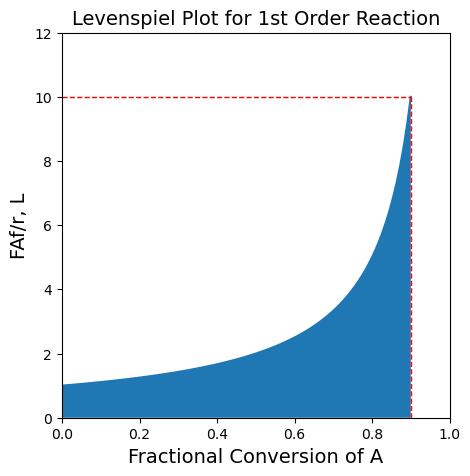

In [5]:
LEV  = lambda X: FAf/k/CAf/(1 - X)
VC   = LEV(0.9)*(0.9 - 0.0)
VP   = trapezoid(LEV(xspan), xspan)
print(f'To achieve 90% conversion, we need a {VC:3.2f}L CSTR or a {VP:3.2f}L PFR') 

plt2 = plt.figure(figsize = (5, 5))
plt.plot(xspan, LEV(xspan))
plt.hlines(LEV(0.9), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.9, 0, LEV(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.fill_between(xspan, LEV(xspan))
plt.xlabel('Fractional Conversion of A', fontsize = 14)
plt.ylabel('FAf/r, L', fontsize = 14)
plt.title('Levenspiel Plot for 1st Order Reaction', fontsize = 14)
plt.ylim(0, 12)
plt.xlim(0, 1)
plt.show()

## If we use 2 CSTRs instead of 1 CSTR, the total volume required is lower...

We also looked at how things change when we instead do this in multiple reactors; for example, if we decide to reach 90% total conversion of A in two CSTRs in series, with an intermediate conversion of 45%, we find:

$$V_1 = \frac{F_{A_f}(X_{A_n} - X_{A_{n-1}})}{kC_{A_f}(1-X_{A_{n-1}})} = \frac{(0.45 - 0.00)}{(1 - 0.45)} \ \mathrm{L} = 0.82 \ \mathrm{L}$$
$$V_2 = \frac{F_{A_f}(X_{A_n} - X_{A_{n-1}})}{kC_{A_f}(1-X_{A_{n-1}})} = \frac{(0.90 - 0.45)}{(1 - 0.90)} \ \mathrm{L} = 4.5 \ \mathrm{L}$$
$$V_{\mathrm{total}} = V_1 + V_2 = 5.32 \ \mathrm{L}$$


In [6]:
Vt = VCSTR(0.0, 0.45) + VCSTR(0.45, 0.9)
print(f'If we use two CSTRs with an intermediate conversion of XA1 = 0.45, the total volume required is {Vt:4.2f}L')

If we use two CSTRs with an intermediate conversion of XA1 = 0.45, the total volume required is 5.32L


This scenario is illustrated in the Levenspiel Plot below. As we look at the respective sizes of the red rectangles (which corresponding to the volumes of CSTR 1 and CSTR 2), we might be wondering if an intermediate conversion of $X_{A_1} = 0.45$ is ***the best*** intermediate conversion. By that, we mean is it the intermediate conversion that would result in the smallest total reactor volume? Almost certainly not. We picked $X_{A_1} = 0.45$ arbitrarily for the purpose of illustrating a concept. It is very unlikely that we happened to pick the best possible option. In the cell below, you can adjust the intermediate fractional conversion exiting the first reactor. It is bound to the variable `XA1` in the code cell below. Try adjusting this value -- the Levenspiel Plot and rectangles corresponding to the two CSTR volumes will adjust automatically, and the cell will display the total volume for any new value of `XA1`.

After a bit of trial and error, we can find that setting the intermediate conversion to $X_{A_1} \approx 0.7$ gives a total reactor volume of $V \approx 4.3\mathrm{L}$. This is considerably smaller than the volume of $V = 5.3\mathrm{L}$ we found for $X_{A_1} = 0.45$

For XA1 = 0.45:
 The total PFR volume required is  V = 2.30L
 The total CSTR volume required is V = 5.32L


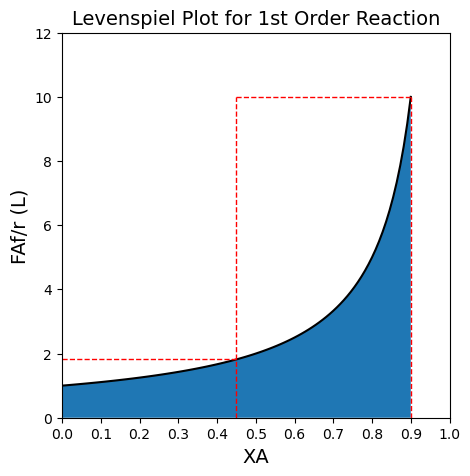

In [7]:
XAset = np.linspace(0, 0.90, 100)
XA1 = 0.45
XA2 = max(XAset)

VPT = VPFR(0.0, XA2)
VC1 = VCSTR(0.0, XA1)
VC2 = VCSTR(XA1, XA2)
VCT = VC1 + VC2
print(f'For XA1 = {XA1:4.2f}:')
print(f' The total PFR volume required is  V = {VPT:3.2f}L') 
print(f' The total CSTR volume required is V = {VCT:3.2f}L')

plt.figure(figsize = (5, 5))
plt.title('Levenspiel Plot for 1st Order Reaction', fontsize = 14)
plt.plot(XAset, LEV(XAset), color = 'black')
plt.fill_between(XAset, LEV(XAset))
plt.vlines(XA1, 0, LEV(XA2), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(XA2, 0, LEV(XA2), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(XA2), XA1, XA2, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(XA1), 0, XA1, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,1)
plt.ylim(0, 12)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

## Example Problem 01: What is the optimum intermediate conversion?

Our trial and error experimentation with the Levenspiel Plot above shows us pretty clearly that there is a better choice of intermediate conversion of $A$ than $X_{A_1} = 0.45$, and we can estimate that the optimal value is probably near $X_{A_1} = 0.70$. Although that exercise is educational and easy to visualize, it is a rough optimum, and it isn't yet clear to me that we have found ***the best*** intermediate conversion. it isn't immediately clear how I should operate this process so that I have the smallest total possible CSTR volume. To do this, we want to be more mathematically rigorous. At this point, we will introduce the concept of an objective function for optimization.  In plain terms, this is a function that cacluates (and returns!) the ***quantity that we are trying to optimize as a function of the parameter we are trying to optimize with respect to***. We should also establish that, in most cases, when we talk about "optimizing" a function, we really mean "minimizing" a function as most optimization algorithms are designed to find the smallest value of a function, not the largest value of a function.

### Define an objective function

In this particular instance of "optimization," we are trying to minimize the total CSTR volume as a function of intermediate conversion, i.e., conversion exiting the first reactor, $X_{A_1}$.  A reasonable objective function is then going to be one that (1) takes $X_{A_1}$ as its only argument and (2) returns total CSTR volume as its only output. For example:

$$V(X_{A_1}) = \frac {F_{A_f} (X_{A_1} - X_{A_{0}} ) } {kC_{A_f}(1-X_{A_{1}})} + \frac {F_{A_f} (X_{A_2} - X_{A_{1}} ) } {kC_{A_f}(1-X_{A_{2}})} $$

It might look like it needs more inputs than just $X_{A_1}$, but for the specific problem we are considering, we know all of the constant values from the problem statement, and we know that $x_{A_0} = 0$ and $x_{A_2} = 0.9$. We do not yet know the best value of $X_{A_1}$, so we pass it to the function as an argument.  Making these substitutions, we get the simplified objective function: 

$$V(X_{A_1}) = \frac{F_{A_f}}{kC_{A_f}} \left[ \frac {X_{A_1}}{(1-X_{A_{1}})} + \frac {(0.9 - X_{A_{1}} )} {0.1} \right] $$

We can now define that function in the cell below, and we'll consider a few ways to analyze it. 

#### Graph the objective function!

We'll start with an intuitive approach, which is to graph it!

```{tip}
If you have a univariate objective function or bivariate objective function, it is straightforward to visualize how the objective varies as a function of input arguments. In these cases, we should always try to graph the objective function as it is much more informative than having only an optimum value!
```

From the graph below, we can see pretty clearly that the objective, total CSTR volume, has a minimum near $X_{A_1} = 0.7$. This is consistent with our conclusion from trial-and-error variation of intermediate conversion using a Levenspiel Plot.

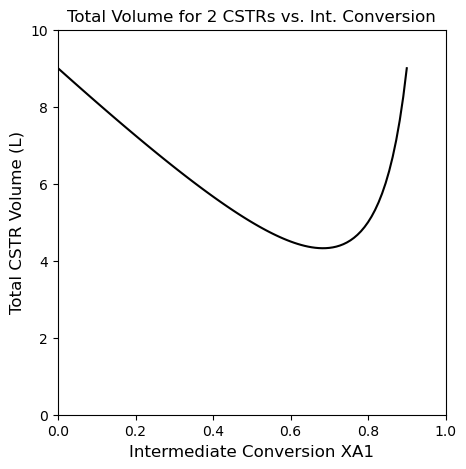

In [8]:
def objective1(X):
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min    
    V = FAf/k/CAf*(X/(1 - X) + (0.9 - X)/0.1)
    return V

xspan = np.linspace(0, 0.9, 100)
V = objective1(xspan)

plt.figure(figsize = (5, 5))
plt.title('Total Volume for 2 CSTRs vs. Int. Conversion')
plt.plot(xspan, V, color = 'black')
plt.xlabel('Intermediate Conversion XA1', fontsize = 12)
plt.ylabel('Total CSTR Volume (L)', fontsize = 12)
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.show()

#### Minimizing the objective function analytically

In some cases, we can find the minimum of an objective function analytically. To do this, we proceed as we would in a calculus course -- we take the derivative of the objective function with respect to the parameter we are trying to optimize with respect to. In this case, we need to take the derivative of $V$ with respect to $X_{A_1}$, we set it equal to zero, and we find the root of the expression. It is not always straightforward or even possible to find the analytical derivative of an objective function, but this is the basic idea of minimization -- we find the point where the derivative of the objective function (with respect to the parameter of interest) is equal to zero. For this particular example, differentiation is somewhat tedious, but it is not especially difficult. Doing so, we find:

$$\frac{dV}{dX_{A_1}} = \frac{F_{A_f}}{kC_{A_f}} \left[ \frac{ (1-X_{A_1}) + X_{A_1} }{ (1 - X_{A_1})^2} - 10\right]$$

To find the minimum, we solve the following equation for $X_{A_1}$:

$$0 = \frac{1}{(1 - X_{A_1})^2} - 10$$

This is a quadratic, so we could solve it analytically. Alternatively, we could use a univariate equation solver like `opt.newton()`. This is the method used below. Once we find the root, we plug the optimal value of $X_{A_1}$ back into our volume expression; this will be the smallest total CSTR volume that we can achieve using two CSTRs in series!

The optimum intermediate conversion is 0.68, which gives a total volume of 4.32L


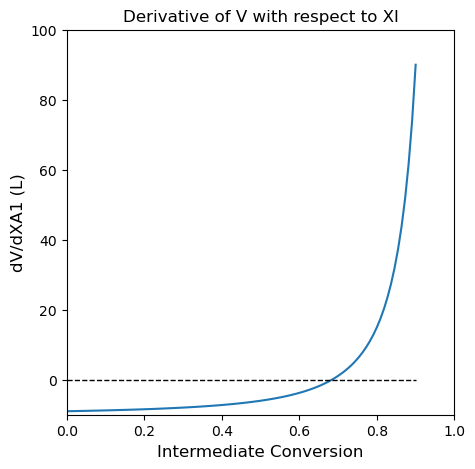

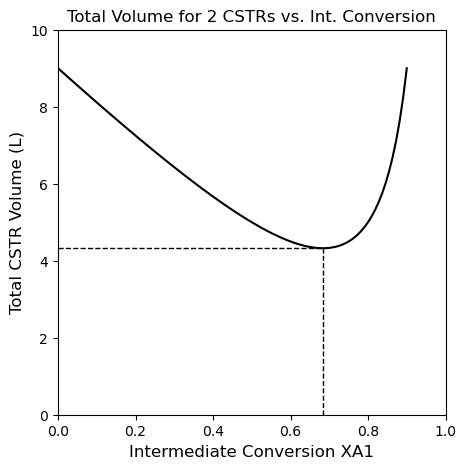

In [61]:
der  = lambda X: FAf/k/CAf*1/(1 - X)**2 - 10
Xopt = opt.newton(der, 0.5)
Vmin = objective1(Xopt)
print(f'The optimum intermediate conversion is {Xopt:3.2f}, which gives a total volume of {Vmin:3.2f}L')

plt.figure(figsize = (5, 5))
plt.title('Derivative of V with respect to XI')
plt.plot(xspan, der(xspan))
plt.hlines(0, 0, 0.9, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlim(0.0, 1.0)
plt.xlabel('Intermediate Conversion', fontsize = 12)
plt.ylim(-10.0, 100.0)
plt.ylabel('dV/dXA1 (L)', fontsize = 12)
plt.show()

plt.figure(figsize = (5, 5))
plt.title('Total Volume for 2 CSTRs vs. Int. Conversion')
plt.plot(xspan, V, color = 'black')
plt.xlabel('Intermediate Conversion XA1', fontsize = 12)
plt.ylabel('Total CSTR Volume (L)', fontsize = 12)
plt.hlines(Vmin, 0, Xopt, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.vlines(Xopt, 0, Vmin, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.show()

#### Minimizing the objective function numerically

Sometimes, it is difficult or even impossible for us to determine a concise, closed-form analytical expression for the derivative of the objective function. In these cases, we would instead use a a numerical method to find the minimum value of the function. (See [Supplement 10](https://jqbond.github.io/CEN587/Supplements/587-S10.html) and [Supplement 11](https://jqbond.github.io/CEN587/Supplements/587-S10.html)). You have probably done this before if you have ever used the Solver add-in for Excel to minimize a function value -- it uses similar algorithms to those in Python. The approach is similar to the one we would take for analytical minimization of a function -- we write an objective function that calculates the quantity we want to minize with respect to the parameter we want to minimize with respect to.  In this case, we want to **minimize** total CSTR volume in two CSTRs in series **with respect to** intermediate fractional conversion, $X_{A_1}$. That sounds exactly like the objective function that we wrote above! We can then minimize this function using Python's algorithms.

In Python, we have a few available options for numerical optimization (minimization). One useful method for optimizing scalar functions is `scipy.optimize.minimize_scalar()`, which is designed specifically to optimize (find the minimum of) univariate, scalar functions.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

In the cells below, we'll see how to change a few options with minimize scalar to account for additional complexities in the functions we are trying to minimize.  These include changing methods, adding brackets or bounds, and adding options.

In [62]:
def f2(X):
    # print(f'Current int. conversion is {X:0.2f}')
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    V = FAf/k/CAf*(X/(1.0 - X) + (0.9 - X)/0.1)
    # print(f'Which gives a Total volume of {V:0.2f}L \n')
    return V

In [64]:
# opt.minimize_scalar(f2) #uses Bounded optimization with default parameters 
# opt.minimize_scalar(f2, method = 'Golden') #uses Golden Section method with a default parameters
# opt.minimize_scalar(f2, method = 'Brent') #uses Brent's method with a default bracket of (0, 1)
# opt.minimize_scalar(f2, method = 'Brent', bracket = (0.1, 0.9)) #uses Brent's method with a bracket of (0.1, 0.9)
# opt.minimize_scalar(f2, method = 'Bounded', bounds = (0.1, 0.9)) #uses Bounded method with bounds of (0.1, 0.9)
# optset = {'disp' : True} #options are passed to the optimization algorithm using a dictionary of {'key' : value} pairs
# optset['disp']
# optset = {'disp' : True, 'maxiter' : 100}
# opt.minimize_scalar(f2, method = 'Brent', bracket = (0.1, 0.9), options = optset)
# ans2 = opt.minimize_scalar(f2, method = 'Brent', bracket = (0.1, 0.9), options = optset)

## Example Problem 02

Now let's solve a slightly different problem. The previous example minimized the Volume of 2 reactors by varying the intermediate conversion. This is generally an example of minimizing Captial Cost of equipment (CapEx), which is largely determined by the size of the reactor. A more realistic optimization problem would require us to minimize the total total cost of our *process* and/or to maximize the profit generated by that process. In this case, we need to account for CapEx (which increases with the size of a reactor), but we also need to consider Operating Expenses (OpEx), which include raw material costs and expenses associated with running the process (e.g., utilities, wastewater treatment, maintenance, etc.). This is not a Unit Operations or Plant Design Course, so we will not go into substantial detail about calculating Capital and Operating Expenses. We only want to build deeper insight into minimizing the cost of a ***process*** rather than only minimizing the cost of fabricating the reactor. For this purpose, a very simple model for CapEx and OpEx is sufficient. First, we will say that the annualized capital cost of a **single reactor** is given by:

$$\textrm{CapEx} = 3.78V^{2.3} + 20$$

Here $V$ is volume of a reactor in L and CapEx has units of M\\$ per year. As we calculate capital cost, it is important to emphasize that this equation computes the CapEx associated with a single reactor, therefore the input volume is that of a single reactor, not the sum volume of all reactors. If we use the latter, we will draw the conclusion that CapEx is a minimum as the number of CSTRs that we use goes to infinity, which is not realistic since there is substantial cost associated with fabricating each reactor, no matter how small.

OpEx will also have units of M\\$ per year and scale with the number of reactors that we have in the following way:

$$\textrm{OpEx} = 165.3N^\frac{1}{3}$$

We'll also say that, for this simple example, the total annual cost of the process is CapEx plus OpEx.

Our final assumption: Each reactor in the series will accomplish the same incremental change in fractional conversion of species $A$. For example, if we achieve 90% conversion in 2 reactors, each will achieve 45% conversion of $F_{A_f}$.  If we have 10 reactors, each will achieve 9% conversion of $F_{A_f}$, etc. This way, the change in fractional conversion (amount converted) across any reactor is constant, and our CSTR balance on **Reactor n** becomes:

$$V_n = \frac{F_{A_f}\Delta x_A}{kC_{A_f}(1 - x_{A_n})}$$

While we could certainly consider different increments in conversion across each reactor, it makes the problem a multivariate optimization problem, which is more complex and not the topic of discussion in this notebook. We will keep the rest of the information about this problem the same as in Problem 1, i.e.,:

\begin{align}
    r &= kC_A \\
    k &= 1 \ \textrm{min}^{-1} \\
    F_{A_f} &= 1 \ \textrm{mol} \ \textrm{min}^{-1} \\
    C_{A_f} &= 1 \ \textrm{mol} \ \textrm{L}^{-1} \\
\end{align}

How many reactors should we use in order to minimize the total annual cost of the process?

### Solution to Example Problem 02

This problem asks us to determine how many CSTRs we should place in series to minimize the cost of the process. We'll start by creating a function that takes the number of CSTRs, $N$, as an argument. It will then calculate the volume of each CSTR and the total volume of all CSTRs.

In [9]:
#######################################################################################################################
# This is a demonstration of a function that calculates the volume of a single reactor accomplishing 90% conversion   #
# We'll use this as a basis to build a more general function that calculates the volume of each reactor in the series #
#######################################################################################################################

def volcalcn(n):
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    XA  = 0.90
    ΔX  = XA/n
    Vn  = FAf*ΔX/k/CAf/(1 - 0.9)
    return Vn
volcalcn(1)

9.000000000000002

In [23]:
################################################################################################
# This is a more useful CSTR volume calculator for a series of CSTRs                           #
# It takes number of reactors in the series as an argument (N).                                #
# It then uses a for loop to calculate the volume of each reactor in the series                #
# The total volume is given by the sum of all individual reactor volumes                       #
################################################################################################

def volcalc(N):
    FAf = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    XA  = 0.9
    ΔX  = XA/N
    
    reactorset = np.linspace(1, N, N)
    V   = np.zeros(N)
    
    for index, n in enumerate(reactorset):
         V[index] = FAf/CAf/k*ΔX/(1 - n*ΔX)
    Vtot = sum(V)
    return [Vtot, V]

ntest = 3
Vtotal, Vset = volcalc(ntest)

CAP = 3.78*Vset**(2.3) + 20
display(CAP)
display(np.sum(CAP))
OP  = 165.3*ntest**(1/3)
display(OP)

array([20.53844977, 21.9504405 , 67.30103957])

np.float64(109.78992983856728)

238.4038539718146

Now we can use this function inside of an objective function. Here, our objective function should calculate the quantity we are trying to minimize (annual cost of the process) as a function of the parameter that we'd like to minimize with respect to (number of CSTRs in the series).  We have a bit of a challenge here, though: the number of reactors must be an integer quantity. For this reason, we can't use an optimization algorithm as it is very difficult to restrict them to integral values of the parameter that we are varying. Put simply, we need the answer to be 1, 2, 3, 4, 5, ... CSTRs, and an optimization algorithm might conclude that we need 1.57 CSTRs, which is difficult to parse.  As such, we will not use an optimization algorithm. Instead, we'll define the function to calculate CAPEX, OPEX, and COST. We will then use a loop to calculate each of these quantities for various integer values of number of reactors, and then we will graph the result to visualize (1) the behavior of various cost drivers and (2) the optimum number of reactors in the sequence.

Ultimately, we find that OpEx increases monotonically with reactor number, CapEx reaches a minimum at 3 - 4 CSTRs, and the *process* has a minimum cost for 3 CSTRs in series.

In [14]:
######################################################################
# A reasonable objective function for this optimization problem      #
######################################################################

def obj(N):
    Vtot, V = volcalc(N)
    CAPEX = 3.78*V**(2.3) + 20
    CAPEX = np.sum(CAPEX)
    OPEX  = 165.3*N**(1/3)
    COST  = CAPEX + OPEX
    return [CAPEX, OPEX, COST]

The minimum cost is  348M$/yr, which we achieve with 3 CSTRs in series.


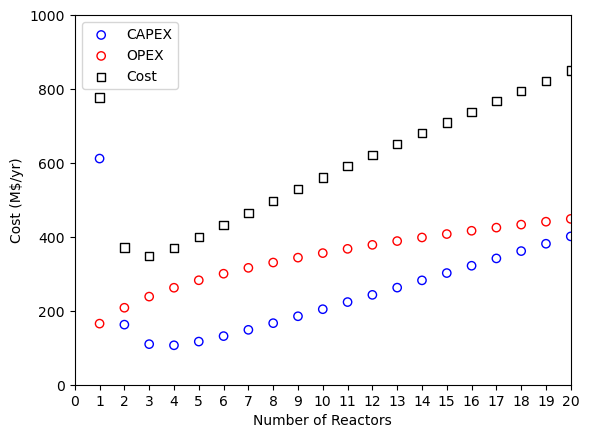

In [60]:
##################################################################
# Use a loop to evaluate CAPEX, OPEX, and COST for various N     #
##################################################################

CAPEX = np.zeros(20)
OPEX  = np.zeros(20)
COST  = np.zeros(20)

nreact = np.linspace(1, 20, 20, dtype = int)
for i, N in enumerate(nreact):
    CAPEX[i], OPEX[i], COST[i] = obj(N)

print(f'The minimum cost is {COST[2]:4.0f}M$/yr, which we achieve with 3 CSTRs in series.')

###############################################################################################
# Graph the results                                                                           #
###############################################################################################

plt.scatter(nreact, CAPEX, color = 'none', edgecolor = 'blue',  marker = 'o', label = 'CAPEX')
plt.scatter(nreact, OPEX,  color = 'none', edgecolor = 'red',   marker = 'o', label = 'OPEX')
plt.scatter(nreact, COST,  color = 'none', edgecolor = 'black', marker = 's', label = 'Cost')
plt.xlim(0, 20)
plt.ylim(0, 1000)
plt.xticks(np.linspace(0, 20, 21))
plt.xlabel('Number of Reactors')
plt.ylabel('Cost (M$/yr)')
plt.legend()
plt.show()